# Setup

In [ ]:
# in conda env
# conda install pytorch torchvision cpuonly -c pytorch
# conda install pytorch torchvision cudatoolkit=10.1 -c pytorch
# pip install cython
# pip install 'git+https://github.com/facebookresearch/detectron2.git'

In [6]:
# Some basic setup
# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import cv2
import random

# import some common detectron2 utilities
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog

# Dataset Handling

In [7]:
import os
import numpy as np
import json
from detectron2.structures import BoxMode
import itertools

# write a function that loads the dataset into detectron2's standard format
def get_oct_dicts(img_dir):
    json_file = os.path.join(img_dir, "via_labels.json")
    with open(json_file) as f:
        imgs_anns = json.load(f)

    dataset_dicts = []
    for idx, v in enumerate(imgs_anns.values()):
        record = {}
        
        filename = os.path.join(img_dir, v["filename"])
        height, width = cv2.imread(filename).shape[:2]
        
        record["file_name"] = filename
        record["image_id"] = idx
        record["height"] = height
        record["width"] = width
      
        annos = v["regions"]
        objs = []
        for anno in annos:
            if anno is None:
                continue
            cat = anno["region_attributes"]["shape"]
            if cat == "druse":
                cat_id = 0
            elif cat == "hr":
                cat_id = 1
            else:
                # skip
                continue

            shape = anno["shape_attributes"]
            bb_x = shape["x"]
            bb_y = shape["y"]
            bb_w = shape["width"]
            bb_h = shape["height"]
            
            obj = {
                "bbox": [bb_x, bb_y, bb_w, bb_h],
                "bbox_mode": BoxMode.XYWH_ABS,
                "category_id": cat_id,
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts

In [8]:
from detectron2.data import DatasetCatalog, MetadataCatalog
DatasetCatalog.clear()
for d in ["train", "val"]:
    DatasetCatalog.register("oct_" + d, lambda d=d: get_oct_dicts("data/" + d))
    MetadataCatalog.get("oct_" + d).set(
        thing_classes=["druse", "hr"],
        stuff_classes=["druse", "hr"])
    oct_train = MetadataCatalog.get("oct_train")
    oct_val = MetadataCatalog.get("oct_val")

# Test Dataloader

In [ ]:
from matplotlib import pyplot as plt

dataset_val = get_oct_dicts("data/val")

for d in random.sample(dataset_val, 5):
    img = cv2.imread(d["file_name"])
    visualizer = Visualizer(img[:, :, ::-1], metadata=oct_val, scale=1.5)
    vis = visualizer.draw_dataset_dict(d)
    
    im_cv = vis.get_image()[:, :, ::-1]
    im_rgb = cv2.cvtColor(im_cv, cv2.COLOR_BGR2RGB)

    plt.figure(figsize=(12,12)),plt.title(d["file_name"]),plt.imshow(im_rgb),plt.show()

# Train

In [4]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg

cfg = get_cfg()
cfg.merge_from_file("./detectron2/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml")
cfg.DATASETS.TRAIN = ("oct_train",)
cfg.DATASETS.TEST = ("oct_val", )
cfg.DATALOADER.NUM_WORKERS = 2
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.MODEL.RETINANET.NUM_CLASSES = 2
# init
#cfg.MODEL.WEIGHTS = False
#cfg.SOLVER.BASE_LR = 0.00001
#cfg.SOLVER.MAX_ITER = 10000

Loading config ./detectron2/configs/COCO-Detection/../Base-RetinaNet.yaml with yaml.unsafe_load. Your machine may be at risk if the file contains malicious content.


WARNING [02/04 16:37:03 d2.config.compat]: Config './detectron2/configs/COCO-Detection/retinanet_R_50_FPN_3x.yaml' has no VERSION. Assuming it to be compatible with latest v2.


In [9]:
import torch
# improve
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
dict_torch = torch.load(cfg.MODEL.WEIGHTS)
dict_torch.pop('scheduler', None)
#dict_torch.pop('iteration', None)
torch.save(dict_torch, cfg.MODEL.WEIGHTS)
cfg.SOLVER.BASE_LR = 0.0001
cfg.SOLVER.MAX_ITER = 70000

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
#trainer.resume_or_load(resume=False)
trainer.resume_or_load(resume=True)
trainer.train()

[02/04 16:38:08 d2.engine.defaults]: Model:
RetinaNet(
  (backbone): FPN(
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelP6P7(
      (p6): Conv2d(2048, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (p7): Conv2d(256, 256, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    )
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res2)

[02/04 16:38:19 d2.data.build]: Removed 0 images with no usable annotations. 3350 images left.
[02/04 16:38:19 d2.data.build]: Distribution of instances among all 2 categories:
|  category  | #instances   |  category  | #instances   |
|:----------:|:-------------|:----------:|:-------------|
|   druse    | 16110        |     hr     | 2200         |
|            |              |            |              |
|   total    | 18310        |            |              |
[02/04 16:38:19 d2.data.detection_utils]: TransformGens used in training: [ResizeShortestEdge(short_edge_length=(640, 672, 704, 736, 768, 800), max_size=1333, sample_style='choice'), RandomFlip()]
[02/04 16:38:19 d2.data.build]: Using training sampler TrainingSampler
[02/04 16:38:20 d2.engine.train_loop]: Starting training from iteration 50000
[02/04 16:38:36 d2.utils.events]: eta: 4:09:32  iter: 50019  total_loss: 0.087  loss_cls: 0.044  loss_box_reg: 0.043  time: 0.7885  data_time: 0.0108  lr: 0.000002  max_mem: 2489M
[02/04 

[02/04 16:48:14 d2.utils.events]: eta: 3:54:39  iter: 50799  total_loss: 0.070  loss_cls: 0.034  loss_box_reg: 0.035  time: 0.7393  data_time: 0.0047  lr: 0.000080  max_mem: 2489M
[02/04 16:48:29 d2.utils.events]: eta: 3:54:37  iter: 50819  total_loss: 0.122  loss_cls: 0.057  loss_box_reg: 0.059  time: 0.7392  data_time: 0.0046  lr: 0.000082  max_mem: 2489M
[02/04 16:48:44 d2.utils.events]: eta: 3:54:28  iter: 50839  total_loss: 0.131  loss_cls: 0.067  loss_box_reg: 0.055  time: 0.7399  data_time: 0.0047  lr: 0.000084  max_mem: 2489M
[02/04 16:48:58 d2.utils.events]: eta: 3:53:37  iter: 50859  total_loss: 0.096  loss_cls: 0.047  loss_box_reg: 0.044  time: 0.7383  data_time: 0.0044  lr: 0.000086  max_mem: 2489M
[02/04 16:49:13 d2.utils.events]: eta: 3:53:47  iter: 50879  total_loss: 0.104  loss_cls: 0.056  loss_box_reg: 0.042  time: 0.7393  data_time: 0.0048  lr: 0.000088  max_mem: 2489M
[02/04 16:49:27 d2.utils.events]: eta: 3:53:08  iter: 50899  total_loss: 0.072  loss_cls: 0.032  los

[02/04 16:59:00 d2.utils.events]: eta: 3:42:02  iter: 51679  total_loss: 0.108  loss_cls: 0.059  loss_box_reg: 0.053  time: 0.7356  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 16:59:14 d2.utils.events]: eta: 3:41:36  iter: 51699  total_loss: 0.070  loss_cls: 0.035  loss_box_reg: 0.042  time: 0.7355  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 16:59:29 d2.utils.events]: eta: 3:41:21  iter: 51719  total_loss: 0.089  loss_cls: 0.044  loss_box_reg: 0.044  time: 0.7355  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 16:59:44 d2.utils.events]: eta: 3:41:03  iter: 51739  total_loss: 0.073  loss_cls: 0.036  loss_box_reg: 0.037  time: 0.7357  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 16:59:58 d2.utils.events]: eta: 3:40:46  iter: 51759  total_loss: 0.073  loss_cls: 0.038  loss_box_reg: 0.036  time: 0.7354  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:00:15 d2.utils.events]: eta: 3:40:38  iter: 51779  total_loss: 0.080  loss_cls: 0.041  los

[02/04 17:09:48 d2.utils.events]: eta: 3:32:53  iter: 52559  total_loss: 0.073  loss_cls: 0.036  loss_box_reg: 0.036  time: 0.7355  data_time: 0.0043  lr: 0.000100  max_mem: 2489M
[02/04 17:10:03 d2.utils.events]: eta: 3:32:38  iter: 52579  total_loss: 0.078  loss_cls: 0.040  loss_box_reg: 0.039  time: 0.7356  data_time: 0.0049  lr: 0.000100  max_mem: 2489M
[02/04 17:10:19 d2.utils.events]: eta: 3:32:23  iter: 52599  total_loss: 0.095  loss_cls: 0.052  loss_box_reg: 0.046  time: 0.7360  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 17:10:33 d2.utils.events]: eta: 3:31:45  iter: 52619  total_loss: 0.083  loss_cls: 0.038  loss_box_reg: 0.042  time: 0.7358  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:10:48 d2.utils.events]: eta: 3:30:46  iter: 52639  total_loss: 0.084  loss_cls: 0.043  loss_box_reg: 0.039  time: 0.7360  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 17:11:04 d2.utils.events]: eta: 3:31:28  iter: 52659  total_loss: 0.104  loss_cls: 0.052  los

[02/04 17:20:38 d2.utils.events]: eta: 3:21:04  iter: 53439  total_loss: 0.080  loss_cls: 0.039  loss_box_reg: 0.038  time: 0.7359  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 17:20:53 d2.utils.events]: eta: 3:20:47  iter: 53459  total_loss: 0.086  loss_cls: 0.041  loss_box_reg: 0.044  time: 0.7360  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:21:08 d2.utils.events]: eta: 3:20:47  iter: 53479  total_loss: 0.101  loss_cls: 0.052  loss_box_reg: 0.046  time: 0.7359  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 17:21:22 d2.utils.events]: eta: 3:20:45  iter: 53499  total_loss: 0.081  loss_cls: 0.041  loss_box_reg: 0.042  time: 0.7358  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:21:37 d2.utils.events]: eta: 3:20:50  iter: 53519  total_loss: 0.092  loss_cls: 0.043  loss_box_reg: 0.041  time: 0.7357  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 17:21:52 d2.utils.events]: eta: 3:20:55  iter: 53539  total_loss: 0.078  loss_cls: 0.037  los

[02/04 17:31:29 d2.utils.events]: eta: 3:10:21  iter: 54319  total_loss: 0.059  loss_cls: 0.033  loss_box_reg: 0.032  time: 0.7364  data_time: 0.0045  lr: 0.000100  max_mem: 2489M
[02/04 17:31:43 d2.utils.events]: eta: 3:10:04  iter: 54339  total_loss: 0.095  loss_cls: 0.046  loss_box_reg: 0.049  time: 0.7362  data_time: 0.0044  lr: 0.000100  max_mem: 2489M
[02/04 17:31:58 d2.utils.events]: eta: 3:09:49  iter: 54359  total_loss: 0.069  loss_cls: 0.033  loss_box_reg: 0.032  time: 0.7362  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 17:32:13 d2.utils.events]: eta: 3:09:48  iter: 54379  total_loss: 0.094  loss_cls: 0.046  loss_box_reg: 0.047  time: 0.7362  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 17:32:27 d2.utils.events]: eta: 3:09:30  iter: 54399  total_loss: 0.070  loss_cls: 0.032  loss_box_reg: 0.035  time: 0.7362  data_time: 0.0051  lr: 0.000100  max_mem: 2489M
[02/04 17:32:42 d2.utils.events]: eta: 3:09:11  iter: 54419  total_loss: 0.095  loss_cls: 0.042  los

[02/04 17:42:19 d2.utils.events]: eta: 3:00:13  iter: 55199  total_loss: 0.073  loss_cls: 0.034  loss_box_reg: 0.035  time: 0.7362  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 17:42:32 d2.utils.events]: eta: 2:59:24  iter: 55219  total_loss: 0.075  loss_cls: 0.035  loss_box_reg: 0.041  time: 0.7360  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 17:42:47 d2.utils.events]: eta: 2:59:16  iter: 55239  total_loss: 0.065  loss_cls: 0.032  loss_box_reg: 0.033  time: 0.7359  data_time: 0.0044  lr: 0.000100  max_mem: 2489M
[02/04 17:43:02 d2.utils.events]: eta: 2:59:07  iter: 55259  total_loss: 0.096  loss_cls: 0.043  loss_box_reg: 0.046  time: 0.7360  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 17:43:17 d2.utils.events]: eta: 2:58:58  iter: 55279  total_loss: 0.080  loss_cls: 0.035  loss_box_reg: 0.036  time: 0.7360  data_time: 0.0049  lr: 0.000100  max_mem: 2489M
[02/04 17:43:32 d2.utils.events]: eta: 2:59:00  iter: 55299  total_loss: 0.096  loss_cls: 0.050  los

[02/04 17:53:07 d2.utils.events]: eta: 2:49:07  iter: 56079  total_loss: 0.066  loss_cls: 0.032  loss_box_reg: 0.034  time: 0.7361  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:53:21 d2.utils.events]: eta: 2:48:35  iter: 56099  total_loss: 0.101  loss_cls: 0.050  loss_box_reg: 0.051  time: 0.7360  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 17:53:36 d2.utils.events]: eta: 2:48:19  iter: 56119  total_loss: 0.076  loss_cls: 0.042  loss_box_reg: 0.038  time: 0.7360  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 17:53:51 d2.utils.events]: eta: 2:48:04  iter: 56139  total_loss: 0.069  loss_cls: 0.039  loss_box_reg: 0.032  time: 0.7360  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 17:54:06 d2.utils.events]: eta: 2:47:50  iter: 56159  total_loss: 0.087  loss_cls: 0.042  loss_box_reg: 0.044  time: 0.7360  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 17:54:20 d2.utils.events]: eta: 2:47:07  iter: 56179  total_loss: 0.084  loss_cls: 0.047  los

[02/04 18:03:57 d2.utils.events]: eta: 2:39:08  iter: 56959  total_loss: 0.080  loss_cls: 0.038  loss_box_reg: 0.039  time: 0.7363  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 18:04:13 d2.utils.events]: eta: 2:39:14  iter: 56979  total_loss: 0.065  loss_cls: 0.032  loss_box_reg: 0.032  time: 0.7363  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 18:04:28 d2.utils.events]: eta: 2:39:30  iter: 56999  total_loss: 0.077  loss_cls: 0.029  loss_box_reg: 0.038  time: 0.7364  data_time: 0.0046  lr: 0.000100  max_mem: 2489M
[02/04 18:04:43 d2.utils.events]: eta: 2:39:18  iter: 57019  total_loss: 0.083  loss_cls: 0.039  loss_box_reg: 0.047  time: 0.7365  data_time: 0.0048  lr: 0.000100  max_mem: 2489M
[02/04 18:04:58 d2.utils.events]: eta: 2:39:05  iter: 57039  total_loss: 0.101  loss_cls: 0.044  loss_box_reg: 0.048  time: 0.7365  data_time: 0.0051  lr: 0.000100  max_mem: 2489M
[02/04 18:05:13 d2.utils.events]: eta: 2:38:58  iter: 57059  total_loss: 0.082  loss_cls: 0.045  los

[02/04 18:14:47 d2.utils.events]: eta: 2:28:48  iter: 57839  total_loss: 0.068  loss_cls: 0.029  loss_box_reg: 0.037  time: 0.7363  data_time: 0.0052  lr: 0.000100  max_mem: 2489M
[02/04 18:15:01 d2.utils.events]: eta: 2:28:32  iter: 57859  total_loss: 0.093  loss_cls: 0.048  loss_box_reg: 0.052  time: 0.7362  data_time: 0.0047  lr: 0.000100  max_mem: 2489M
[02/04 18:15:16 d2.utils.events]: eta: 2:28:04  iter: 57879  total_loss: 0.079  loss_cls: 0.040  loss_box_reg: 0.040  time: 0.7362  data_time: 0.0051  lr: 0.000100  max_mem: 2489M
[02/04 18:15:31 d2.utils.events]: eta: 2:27:24  iter: 57899  total_loss: 0.061  loss_cls: 0.029  loss_box_reg: 0.034  time: 0.7362  data_time: 0.0049  lr: 0.000100  max_mem: 2489M
[02/04 18:15:45 d2.utils.events]: eta: 2:26:41  iter: 57919  total_loss: 0.085  loss_cls: 0.041  loss_box_reg: 0.046  time: 0.7362  data_time: 0.0050  lr: 0.000100  max_mem: 2489M
[02/04 18:16:00 d2.utils.events]: eta: 2:26:22  iter: 57939  total_loss: 0.089  loss_cls: 0.048  los

[02/04 18:25:33 d2.utils.events]: eta: 2:16:08  iter: 58719  total_loss: 0.107  loss_cls: 0.059  loss_box_reg: 0.049  time: 0.7359  data_time: 0.0047  lr: 0.000100  max_mem: 2492M
[02/04 18:25:48 d2.utils.events]: eta: 2:15:53  iter: 58739  total_loss: 0.066  loss_cls: 0.037  loss_box_reg: 0.033  time: 0.7360  data_time: 0.0048  lr: 0.000100  max_mem: 2492M
[02/04 18:26:02 d2.utils.events]: eta: 2:15:45  iter: 58759  total_loss: 0.073  loss_cls: 0.033  loss_box_reg: 0.039  time: 0.7359  data_time: 0.0049  lr: 0.000100  max_mem: 2492M
[02/04 18:26:17 d2.utils.events]: eta: 2:15:34  iter: 58779  total_loss: 0.085  loss_cls: 0.039  loss_box_reg: 0.045  time: 0.7360  data_time: 0.0052  lr: 0.000100  max_mem: 2492M
[02/04 18:26:31 d2.utils.events]: eta: 2:15:14  iter: 58799  total_loss: 0.094  loss_cls: 0.041  loss_box_reg: 0.044  time: 0.7358  data_time: 0.0049  lr: 0.000100  max_mem: 2492M
[02/04 18:26:46 d2.utils.events]: eta: 2:15:03  iter: 58819  total_loss: 0.058  loss_cls: 0.030  los

[02/04 18:36:24 d2.utils.events]: eta: 2:06:08  iter: 59599  total_loss: 0.072  loss_cls: 0.041  loss_box_reg: 0.035  time: 0.7361  data_time: 0.0048  lr: 0.000100  max_mem: 2492M
[02/04 18:36:38 d2.utils.events]: eta: 2:05:54  iter: 59619  total_loss: 0.087  loss_cls: 0.034  loss_box_reg: 0.038  time: 0.7360  data_time: 0.0050  lr: 0.000100  max_mem: 2492M
[02/04 18:36:52 d2.utils.events]: eta: 2:05:36  iter: 59639  total_loss: 0.073  loss_cls: 0.034  loss_box_reg: 0.037  time: 0.7360  data_time: 0.0051  lr: 0.000100  max_mem: 2492M
[02/04 18:37:06 d2.utils.events]: eta: 2:05:22  iter: 59659  total_loss: 0.064  loss_cls: 0.025  loss_box_reg: 0.034  time: 0.7360  data_time: 0.0050  lr: 0.000100  max_mem: 2492M
[02/04 18:37:22 d2.utils.events]: eta: 2:05:11  iter: 59679  total_loss: 0.085  loss_cls: 0.040  loss_box_reg: 0.040  time: 0.7360  data_time: 0.0050  lr: 0.000100  max_mem: 2495M
[02/04 18:37:37 d2.utils.events]: eta: 2:04:53  iter: 59699  total_loss: 0.080  loss_cls: 0.041  los

[02/04 18:47:16 d2.utils.events]: eta: 1:56:27  iter: 60479  total_loss: 0.084  loss_cls: 0.046  loss_box_reg: 0.041  time: 0.7363  data_time: 0.0050  lr: 0.000100  max_mem: 2495M
[02/04 18:47:30 d2.utils.events]: eta: 1:56:09  iter: 60499  total_loss: 0.054  loss_cls: 0.031  loss_box_reg: 0.029  time: 0.7363  data_time: 0.0050  lr: 0.000100  max_mem: 2495M
[02/04 18:47:45 d2.utils.events]: eta: 1:55:52  iter: 60519  total_loss: 0.074  loss_cls: 0.037  loss_box_reg: 0.040  time: 0.7362  data_time: 0.0049  lr: 0.000100  max_mem: 2495M
[02/04 18:48:01 d2.utils.events]: eta: 1:56:00  iter: 60539  total_loss: 0.076  loss_cls: 0.038  loss_box_reg: 0.035  time: 0.7364  data_time: 0.0054  lr: 0.000100  max_mem: 2495M
[02/04 18:48:16 d2.utils.events]: eta: 1:55:57  iter: 60559  total_loss: 0.074  loss_cls: 0.031  loss_box_reg: 0.034  time: 0.7364  data_time: 0.0054  lr: 0.000100  max_mem: 2495M
[02/04 18:48:30 d2.utils.events]: eta: 1:55:32  iter: 60579  total_loss: 0.066  loss_cls: 0.034  los

[02/04 18:58:06 d2.utils.events]: eta: 1:45:58  iter: 61359  total_loss: 0.056  loss_cls: 0.026  loss_box_reg: 0.029  time: 0.7363  data_time: 0.0056  lr: 0.000100  max_mem: 2495M
[02/04 18:58:21 d2.utils.events]: eta: 1:45:42  iter: 61379  total_loss: 0.086  loss_cls: 0.042  loss_box_reg: 0.044  time: 0.7364  data_time: 0.0055  lr: 0.000100  max_mem: 2495M
[02/04 18:58:36 d2.utils.events]: eta: 1:45:22  iter: 61399  total_loss: 0.074  loss_cls: 0.035  loss_box_reg: 0.040  time: 0.7364  data_time: 0.0055  lr: 0.000100  max_mem: 2495M
[02/04 18:58:51 d2.utils.events]: eta: 1:44:45  iter: 61419  total_loss: 0.055  loss_cls: 0.029  loss_box_reg: 0.028  time: 0.7364  data_time: 0.0055  lr: 0.000100  max_mem: 2495M
[02/04 18:59:05 d2.utils.events]: eta: 1:44:30  iter: 61439  total_loss: 0.058  loss_cls: 0.023  loss_box_reg: 0.030  time: 0.7363  data_time: 0.0053  lr: 0.000100  max_mem: 2495M
[02/04 18:59:20 d2.utils.events]: eta: 1:44:15  iter: 61459  total_loss: 0.090  loss_cls: 0.039  los

[02/04 19:08:53 d2.utils.events]: eta: 1:34:11  iter: 62239  total_loss: 0.070  loss_cls: 0.031  loss_box_reg: 0.038  time: 0.7361  data_time: 0.0056  lr: 0.000100  max_mem: 2495M
[02/04 19:09:07 d2.utils.events]: eta: 1:33:57  iter: 62259  total_loss: 0.087  loss_cls: 0.044  loss_box_reg: 0.044  time: 0.7361  data_time: 0.0057  lr: 0.000100  max_mem: 2495M
[02/04 19:09:23 d2.utils.events]: eta: 1:33:44  iter: 62279  total_loss: 0.100  loss_cls: 0.048  loss_box_reg: 0.048  time: 0.7362  data_time: 0.0057  lr: 0.000100  max_mem: 2495M
[02/04 19:09:38 d2.utils.events]: eta: 1:33:29  iter: 62299  total_loss: 0.074  loss_cls: 0.035  loss_box_reg: 0.038  time: 0.7362  data_time: 0.0052  lr: 0.000100  max_mem: 2495M
[02/04 19:09:52 d2.utils.events]: eta: 1:33:12  iter: 62319  total_loss: 0.077  loss_cls: 0.037  loss_box_reg: 0.034  time: 0.7361  data_time: 0.0052  lr: 0.000100  max_mem: 2495M
[02/04 19:10:07 d2.utils.events]: eta: 1:32:59  iter: 62339  total_loss: 0.075  loss_cls: 0.035  los

[02/04 19:19:45 d2.utils.events]: eta: 1:24:16  iter: 63119  total_loss: 0.070  loss_cls: 0.039  loss_box_reg: 0.031  time: 0.7363  data_time: 0.0049  lr: 0.000100  max_mem: 2495M
[02/04 19:20:01 d2.utils.events]: eta: 1:23:59  iter: 63139  total_loss: 0.087  loss_cls: 0.043  loss_box_reg: 0.042  time: 0.7364  data_time: 0.0053  lr: 0.000100  max_mem: 2495M
[02/04 19:20:15 d2.utils.events]: eta: 1:23:44  iter: 63159  total_loss: 0.099  loss_cls: 0.047  loss_box_reg: 0.044  time: 0.7364  data_time: 0.0049  lr: 0.000100  max_mem: 2495M
[02/04 19:20:30 d2.utils.events]: eta: 1:23:31  iter: 63179  total_loss: 0.073  loss_cls: 0.035  loss_box_reg: 0.038  time: 0.7363  data_time: 0.0051  lr: 0.000100  max_mem: 2495M
[02/04 19:20:45 d2.utils.events]: eta: 1:23:17  iter: 63199  total_loss: 0.071  loss_cls: 0.033  loss_box_reg: 0.037  time: 0.7364  data_time: 0.0050  lr: 0.000100  max_mem: 2495M
[02/04 19:20:59 d2.utils.events]: eta: 1:23:01  iter: 63219  total_loss: 0.067  loss_cls: 0.035  los

[02/04 19:30:40 d2.utils.events]: eta: 1:13:06  iter: 63999  total_loss: 0.050  loss_cls: 0.024  loss_box_reg: 0.028  time: 0.7367  data_time: 0.0056  lr: 0.000100  max_mem: 2495M
[02/04 19:30:55 d2.utils.events]: eta: 1:12:55  iter: 64019  total_loss: 0.065  loss_cls: 0.031  loss_box_reg: 0.035  time: 0.7367  data_time: 0.0054  lr: 0.000100  max_mem: 2495M
[02/04 19:31:11 d2.utils.events]: eta: 1:12:53  iter: 64039  total_loss: 0.054  loss_cls: 0.024  loss_box_reg: 0.030  time: 0.7368  data_time: 0.0055  lr: 0.000100  max_mem: 2495M
[02/04 19:31:25 d2.utils.events]: eta: 1:12:38  iter: 64059  total_loss: 0.079  loss_cls: 0.037  loss_box_reg: 0.033  time: 0.7368  data_time: 0.0054  lr: 0.000100  max_mem: 2495M
[02/04 19:31:39 d2.utils.events]: eta: 1:12:13  iter: 64079  total_loss: 0.070  loss_cls: 0.035  loss_box_reg: 0.033  time: 0.7367  data_time: 0.0054  lr: 0.000100  max_mem: 2495M
[02/04 19:31:54 d2.utils.events]: eta: 1:12:00  iter: 64099  total_loss: 0.062  loss_cls: 0.026  los

[02/04 19:41:29 d2.utils.events]: eta: 1:02:39  iter: 64879  total_loss: 0.059  loss_cls: 0.022  loss_box_reg: 0.036  time: 0.7367  data_time: 0.0052  lr: 0.000100  max_mem: 2511M
[02/04 19:41:44 d2.utils.events]: eta: 1:02:22  iter: 64899  total_loss: 0.076  loss_cls: 0.035  loss_box_reg: 0.041  time: 0.7367  data_time: 0.0052  lr: 0.000100  max_mem: 2511M
[02/04 19:41:59 d2.utils.events]: eta: 1:02:06  iter: 64919  total_loss: 0.092  loss_cls: 0.041  loss_box_reg: 0.047  time: 0.7367  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 19:42:15 d2.utils.events]: eta: 1:01:53  iter: 64939  total_loss: 0.069  loss_cls: 0.033  loss_box_reg: 0.035  time: 0.7367  data_time: 0.0050  lr: 0.000100  max_mem: 2511M
[02/04 19:42:30 d2.utils.events]: eta: 1:01:41  iter: 64959  total_loss: 0.076  loss_cls: 0.038  loss_box_reg: 0.038  time: 0.7368  data_time: 0.0050  lr: 0.000100  max_mem: 2511M
[02/04 19:42:45 d2.utils.events]: eta: 1:01:27  iter: 64979  total_loss: 0.064  loss_cls: 0.032  los

[02/04 19:52:19 d2.utils.events]: eta: 0:51:22  iter: 65759  total_loss: 0.063  loss_cls: 0.028  loss_box_reg: 0.034  time: 0.7365  data_time: 0.0048  lr: 0.000100  max_mem: 2511M
[02/04 19:52:33 d2.utils.events]: eta: 0:51:05  iter: 65779  total_loss: 0.099  loss_cls: 0.039  loss_box_reg: 0.047  time: 0.7365  data_time: 0.0054  lr: 0.000100  max_mem: 2511M
[02/04 19:52:48 d2.utils.events]: eta: 0:50:52  iter: 65799  total_loss: 0.076  loss_cls: 0.043  loss_box_reg: 0.038  time: 0.7366  data_time: 0.0049  lr: 0.000100  max_mem: 2511M
[02/04 19:53:04 d2.utils.events]: eta: 0:50:38  iter: 65819  total_loss: 0.066  loss_cls: 0.031  loss_box_reg: 0.034  time: 0.7366  data_time: 0.0049  lr: 0.000100  max_mem: 2511M
[02/04 19:53:18 d2.utils.events]: eta: 0:50:29  iter: 65839  total_loss: 0.083  loss_cls: 0.038  loss_box_reg: 0.043  time: 0.7366  data_time: 0.0048  lr: 0.000100  max_mem: 2511M
[02/04 19:53:33 d2.utils.events]: eta: 0:50:14  iter: 65859  total_loss: 0.066  loss_cls: 0.034  los

[02/04 20:03:08 d2.utils.events]: eta: 0:40:45  iter: 66639  total_loss: 0.076  loss_cls: 0.038  loss_box_reg: 0.035  time: 0.7365  data_time: 0.0049  lr: 0.000100  max_mem: 2511M
[02/04 20:03:23 d2.utils.events]: eta: 0:40:32  iter: 66659  total_loss: 0.095  loss_cls: 0.043  loss_box_reg: 0.051  time: 0.7365  data_time: 0.0053  lr: 0.000100  max_mem: 2511M
[02/04 20:03:38 d2.utils.events]: eta: 0:40:19  iter: 66679  total_loss: 0.071  loss_cls: 0.036  loss_box_reg: 0.035  time: 0.7366  data_time: 0.0048  lr: 0.000100  max_mem: 2511M
[02/04 20:03:53 d2.utils.events]: eta: 0:40:03  iter: 66699  total_loss: 0.080  loss_cls: 0.035  loss_box_reg: 0.044  time: 0.7366  data_time: 0.0048  lr: 0.000100  max_mem: 2511M
[02/04 20:04:07 d2.utils.events]: eta: 0:39:49  iter: 66719  total_loss: 0.094  loss_cls: 0.049  loss_box_reg: 0.042  time: 0.7366  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:04:22 d2.utils.events]: eta: 0:39:34  iter: 66739  total_loss: 0.061  loss_cls: 0.030  los

[02/04 20:14:00 d2.utils.events]: eta: 0:30:23  iter: 67519  total_loss: 0.079  loss_cls: 0.032  loss_box_reg: 0.041  time: 0.7367  data_time: 0.0052  lr: 0.000100  max_mem: 2511M
[02/04 20:14:15 d2.utils.events]: eta: 0:30:08  iter: 67539  total_loss: 0.065  loss_cls: 0.034  loss_box_reg: 0.033  time: 0.7367  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:14:31 d2.utils.events]: eta: 0:29:58  iter: 67559  total_loss: 0.104  loss_cls: 0.052  loss_box_reg: 0.043  time: 0.7367  data_time: 0.0053  lr: 0.000100  max_mem: 2511M
[02/04 20:14:45 d2.utils.events]: eta: 0:29:37  iter: 67579  total_loss: 0.064  loss_cls: 0.032  loss_box_reg: 0.034  time: 0.7367  data_time: 0.0054  lr: 0.000100  max_mem: 2511M
[02/04 20:15:00 d2.utils.events]: eta: 0:29:21  iter: 67599  total_loss: 0.076  loss_cls: 0.036  loss_box_reg: 0.036  time: 0.7367  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:15:15 d2.utils.events]: eta: 0:29:06  iter: 67619  total_loss: 0.086  loss_cls: 0.041  los

[02/04 20:24:50 d2.utils.events]: eta: 0:19:33  iter: 68399  total_loss: 0.054  loss_cls: 0.026  loss_box_reg: 0.030  time: 0.7367  data_time: 0.0048  lr: 0.000100  max_mem: 2511M
[02/04 20:25:05 d2.utils.events]: eta: 0:19:17  iter: 68419  total_loss: 0.074  loss_cls: 0.035  loss_box_reg: 0.040  time: 0.7367  data_time: 0.0049  lr: 0.000100  max_mem: 2511M
[02/04 20:25:20 d2.utils.events]: eta: 0:19:02  iter: 68439  total_loss: 0.059  loss_cls: 0.031  loss_box_reg: 0.030  time: 0.7367  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:25:35 d2.utils.events]: eta: 0:18:44  iter: 68459  total_loss: 0.080  loss_cls: 0.037  loss_box_reg: 0.041  time: 0.7367  data_time: 0.0049  lr: 0.000100  max_mem: 2511M
[02/04 20:25:50 d2.utils.events]: eta: 0:18:27  iter: 68479  total_loss: 0.071  loss_cls: 0.028  loss_box_reg: 0.037  time: 0.7367  data_time: 0.0050  lr: 0.000100  max_mem: 2511M
[02/04 20:26:04 d2.utils.events]: eta: 0:18:11  iter: 68499  total_loss: 0.067  loss_cls: 0.031  los

[02/04 20:35:44 d2.utils.events]: eta: 0:08:46  iter: 69279  total_loss: 0.076  loss_cls: 0.042  loss_box_reg: 0.035  time: 0.7369  data_time: 0.0052  lr: 0.000100  max_mem: 2511M
[02/04 20:35:58 d2.utils.events]: eta: 0:08:31  iter: 69299  total_loss: 0.060  loss_cls: 0.027  loss_box_reg: 0.032  time: 0.7369  data_time: 0.0050  lr: 0.000100  max_mem: 2511M
[02/04 20:36:13 d2.utils.events]: eta: 0:08:16  iter: 69319  total_loss: 0.070  loss_cls: 0.034  loss_box_reg: 0.038  time: 0.7368  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:36:27 d2.utils.events]: eta: 0:08:02  iter: 69339  total_loss: 0.077  loss_cls: 0.039  loss_box_reg: 0.039  time: 0.7368  data_time: 0.0051  lr: 0.000100  max_mem: 2511M
[02/04 20:36:41 d2.utils.events]: eta: 0:07:46  iter: 69359  total_loss: 0.072  loss_cls: 0.038  loss_box_reg: 0.030  time: 0.7368  data_time: 0.0052  lr: 0.000100  max_mem: 2511M
[02/04 20:36:56 d2.utils.events]: eta: 0:07:32  iter: 69379  total_loss: 0.073  loss_cls: 0.033  los

{}

# Inference & Evaluation

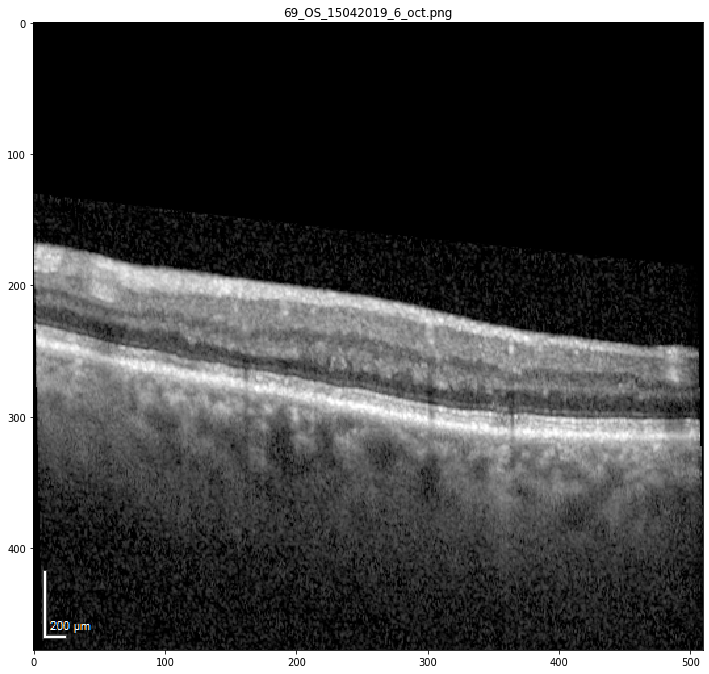

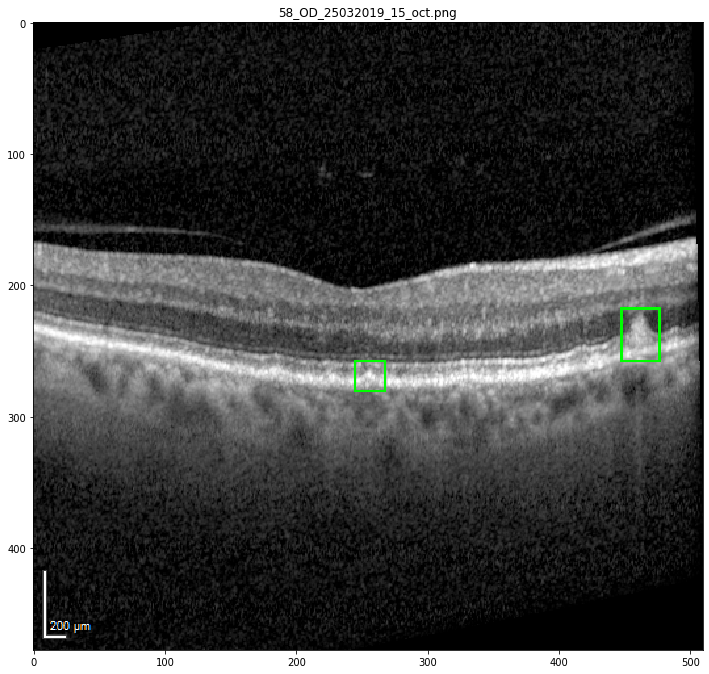

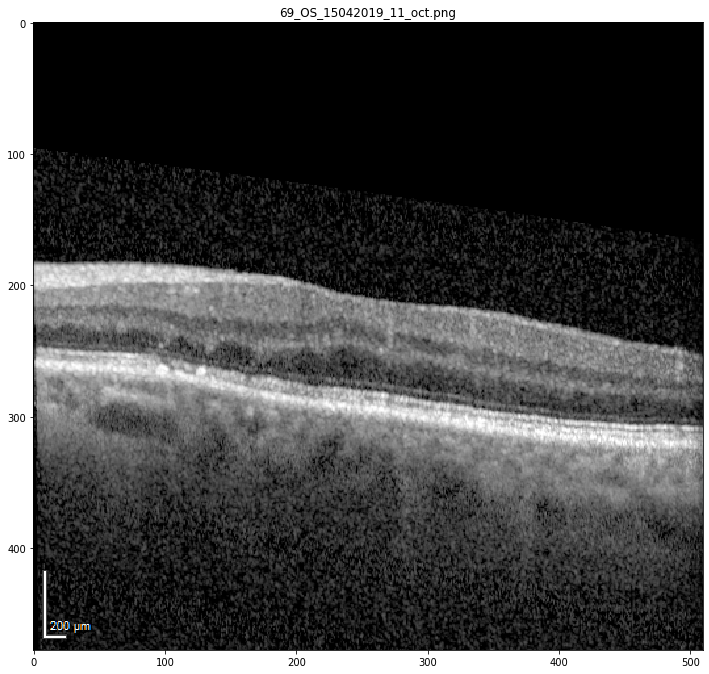

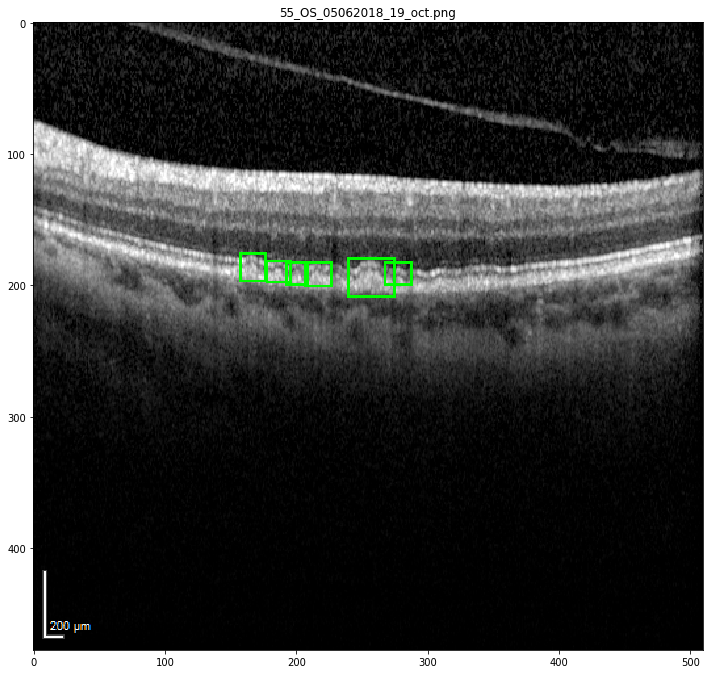

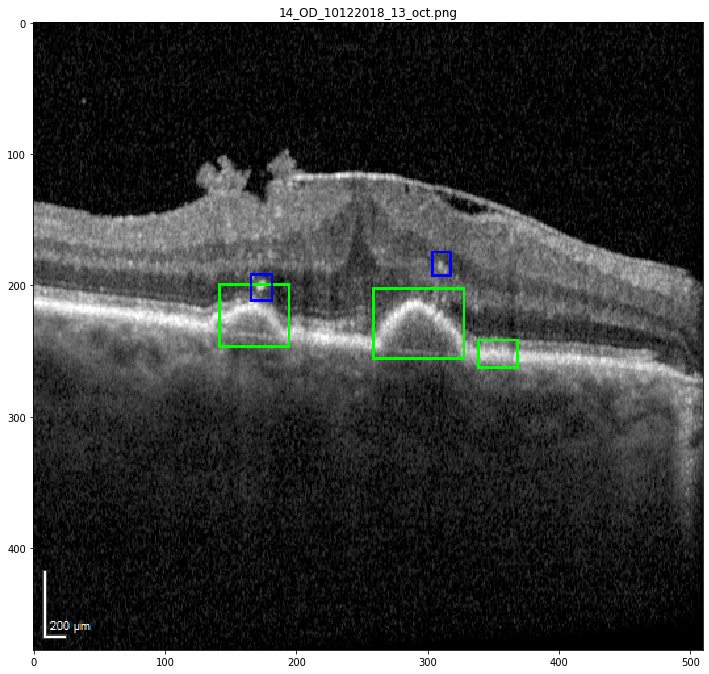

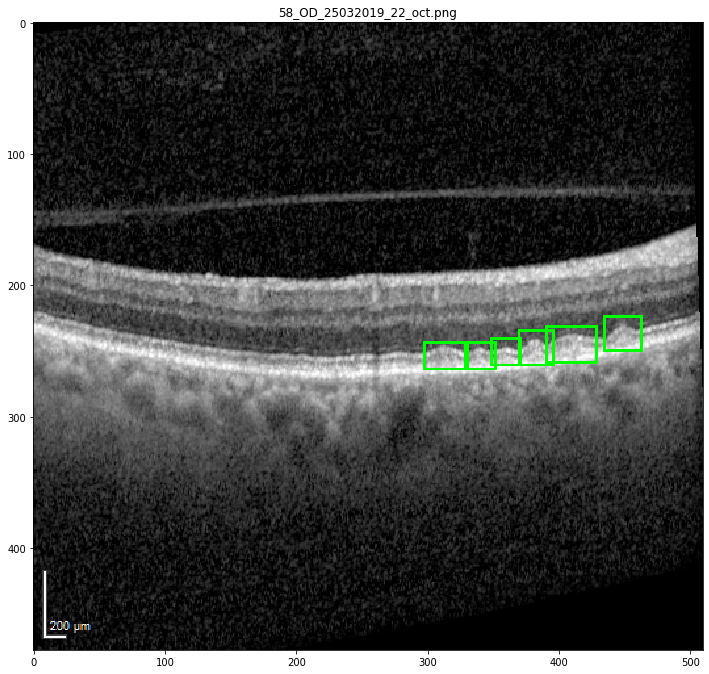

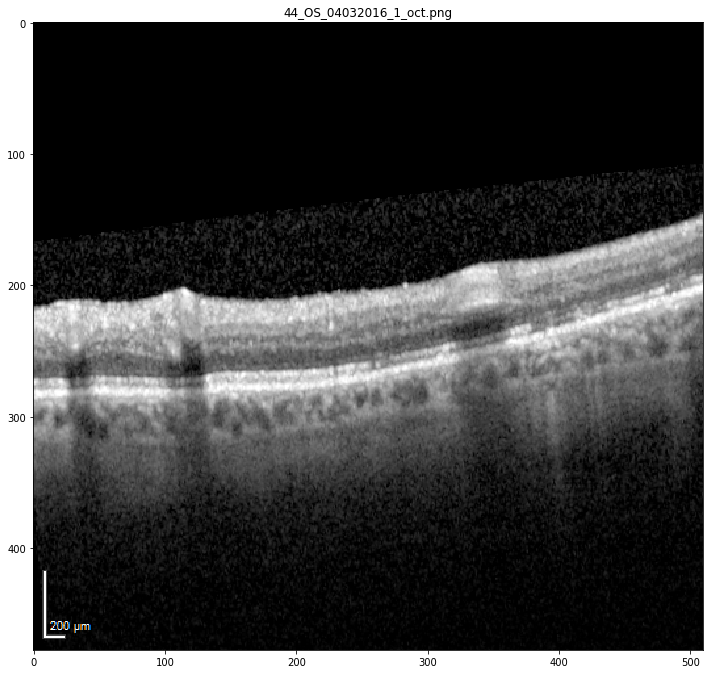

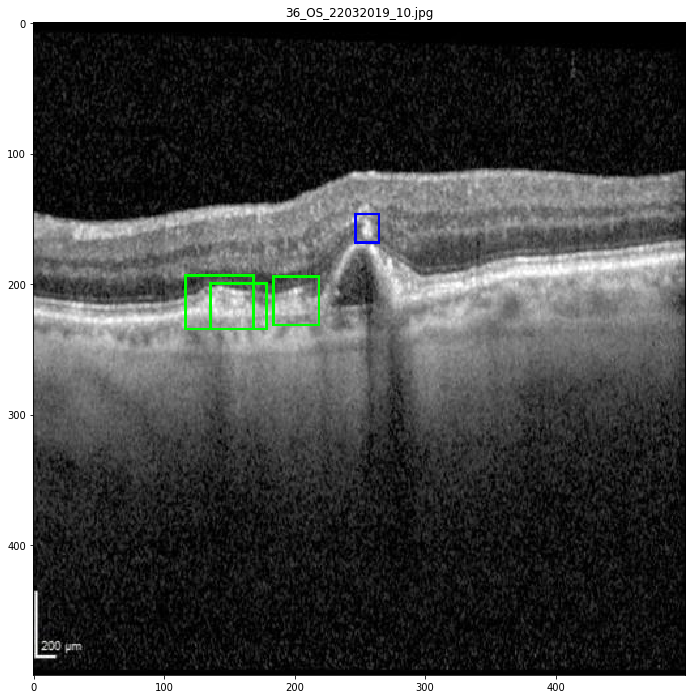

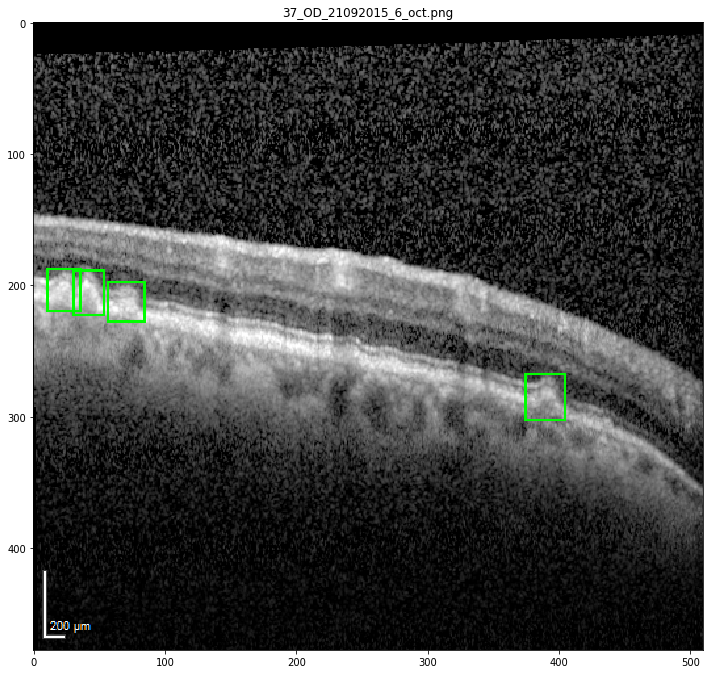

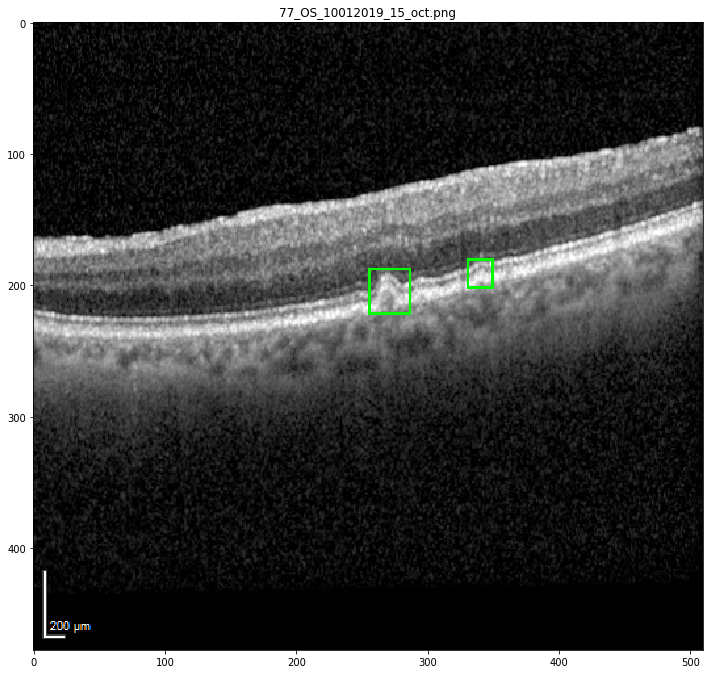

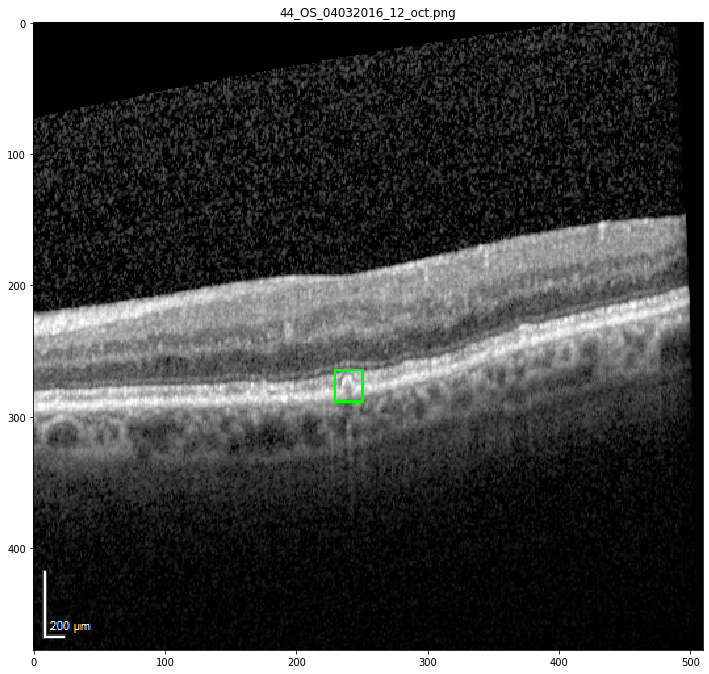

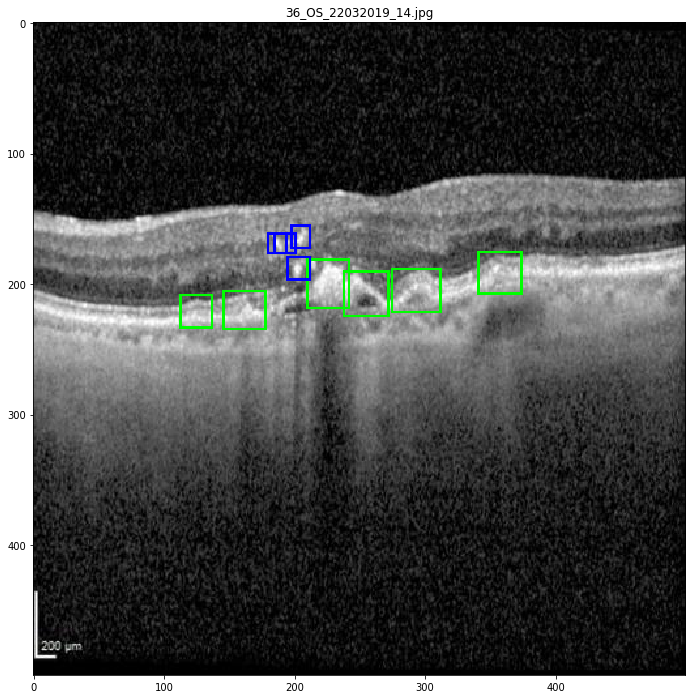

In [19]:
from os import listdir
from os.path import isfile, join
import copy
import cv2
import matplotlib.pyplot as plt
import imgaug as ia
import imgaug.augmenters as iaa
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage

cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.1
dir_test = 'data/test'
dict_label = {0: 'druse', 1: 'hr'}
blue = [0, 0, 255]
green = [0, 255, 0]

def denoise(im):
    grey = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    denoise = cv2.fastNlMeansDenoising(grey, None, 11, 5, 19)
    ret, thresh = cv2.threshold(denoise,25,255,cv2.THRESH_TOZERO)
    im_denoise = cv2.cvtColor(thresh, cv2.COLOR_GRAY2BGR)
    return(im_denoise)

cfg.MODEL.WEIGHTS = 'model_final.pth'
# use two predictors
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.66
predictor_high = DefaultPredictor(cfg)
cfg.MODEL.RETINANET.SCORE_THRESH_TEST = 0.25
predictor_low = DefaultPredictor(cfg)

files_test = [f for f in listdir(dir_test) if isfile(join(dir_test, f))]
for f in files_test:
    file_test = join(dir_test, f)   
    org = cv2.imread(file_test)

    im = copy.copy(org)
    im = denoise(im)
    outputs_high = predictor_high(im)
    outputs_low = predictor_low(im)

    # get prediction
    fields_high = outputs_high['instances'].get_fields()
    boxes_high = fields_high['pred_boxes']
    classes_high = fields_high['pred_classes']
    scores_high = fields_high['scores']
    fields_low = outputs_low['instances'].get_fields()
    boxes_low = fields_low['pred_boxes']
    classes_low = fields_low['pred_classes']
    scores_low = fields_low['scores']

    bbs0 = []
    bbs1 = []
    for i, bb in enumerate(boxes_high.tensor):
        x1 = bb[0].item()
        y1 = bb[1].item()
        x2 = bb[2].item()
        y2 = bb[3].item()
        idx = classes_high[i].item()
        BB = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label = dict_label[idx])
        if idx == 0:
            bbs0.append(BB)
    for i, bb in enumerate(boxes_low.tensor):
        x1 = bb[0].item()
        y1 = bb[1].item()
        x2 = bb[2].item()
        y2 = bb[3].item()
        idx = classes_low[i].item()
        BB = BoundingBox(x1=x1, y1=y1, x2=x2, y2=y2, label = dict_label[idx])
        if idx == 1:
            bbs1.append(BB)
    bbs0 = BoundingBoxesOnImage(bbs0, im.shape)
    bbs1 = BoundingBoxesOnImage(bbs1, im.shape)

    im_pred = bbs0.draw_on_image(org, size = 2, color=green)
    im_pred = bbs1.draw_on_image(im_pred, size = 2, color=blue)
    fig = plt.figure(figsize=(12,12))
    plt.title(f)
    plt.imshow(im_pred)
    plt.show()
    fig.savefig(f)


## Ausblick
- Obige Ergebnisse nach 6h Training auf einer einfachen GPU
- Zuversichtlich, dass man darauf einiges aufbauen kann
- Sowohl im denoise part, als auch in der Extraktion gibt es noch Potenzial nach oben
- Empfehlung: Für Inference das Modell selbst nochmal nachbauen, damit man für die Prediction von Detectron unabhängig wird. Detectron selbst ist zum Training sehr gut und insbesondere auch schnell, aber für Prediction besonders auf CPU Systemen eine Qual zu installieren.
- Empfehlung: Bounding Boxes extrahieren und darauf, anschließend filtern (denoise z.B.) und darauf dann ein neues Modell trainieren, dass eine segmantic segmentation durchführt